In [123]:
!pip install tensorflow>=2.4.0
!pip install kagglehub
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

In [124]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import cv2

In [125]:
BASE_DIR = '/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')
MODEL_PATH = 'efficientnet_retinopathy_best.h5'

In [126]:
# Image parameters
IMG_SIZE = 224  # EfficientNet recommended input size
BATCH_SIZE = 10

In [127]:
CLASS_MAPPING = {0: 'No_Dr', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative DR'}

In [128]:
def visualize_data(dataset_path):
    class_names = os.listdir(dataset_path)
    fig, axes = plt.subplots(1, 5, figsize=(12, 6))
    for i, class_name in enumerate(class_names[:5]):
        img_path = os.path.join(dataset_path, class_name, os.listdir(os.path.join(dataset_path, class_name))[0])
        print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        
        axes[i].imshow(image)
        axes[i].set_title(f"Original: {class_name}")
        axes[i].axis('off')
    
    plt.show()

# Load dataset path and visualize

visualize_data(TRAIN_DIR)

/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/2/11288_left._aug_7.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/0/17169_left.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/3/531_right._aug_16.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/1/8275_right._aug_20._aug_2.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/4/29058_right._aug_22._aug_26.jpeg


In [129]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

In [130]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

Found 34792 images belonging to 5 classes.


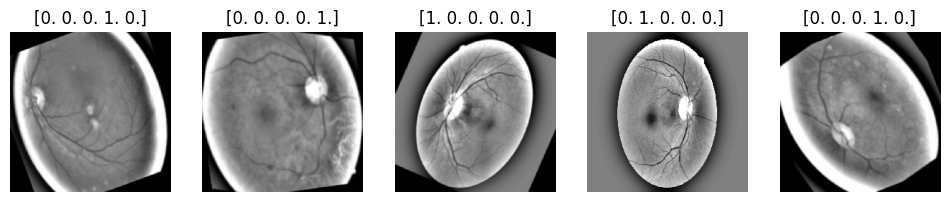

In [131]:
images, labels = next(train_generator)# Fetch first batch

# Plot the first 5 images in the batch
fig, axes = plt.subplots(1, 5, figsize=(12, 6))
for i in range(5):  # Display first 5 images
    axes[i].set_title(str(labels[i]))
    axes[i].imshow((images[i]))# Convert to uint8 for display
    axes[i].axis("off")
    
plt.show()

In [132]:
labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights)

[0.99405714 1.02449941 0.99405714 0.99405714 0.99405714]


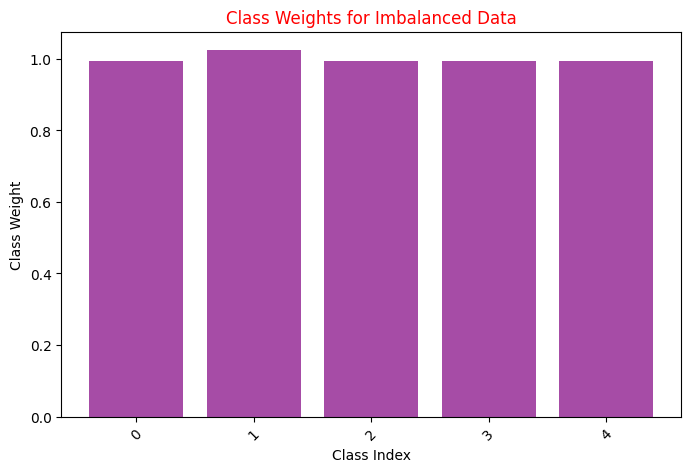

In [133]:
# Visualizing Class Weights
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_weights)), class_weights, color='purple', alpha=0.7)
plt.xlabel("Class Index")
plt.ylabel("Class Weight")
plt.title("Class Weights for Imbalanced Data", fontsize=12, color='red')
plt.xticks(range(len(class_weights)), labels=np.unique(labels), rotation=45)
plt.show()

In [134]:
from collections import Counter
print(Counter(train_generator.classes))  # See class distribution
print(labels[:5]) 

Counter({0: 7000, 2: 7000, 3: 7000, 4: 7000, 1: 6792})
[0 0 0 0 0]


In [135]:
validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

Found 9940 images belonging to 5 classes.


In [136]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

Found 4971 images belonging to 5 classes.


In [137]:
base_model = tf.keras.applications.ResNet152V2(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [138]:
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [139]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),  # Added to avoid shape mismatch issues
    Dropout(0.5),
    BatchNormalization(),
    
    Dense(256, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(128, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(5, activation='softmax')  # 5-class classification
])


In [140]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),       
    tf.keras.metrics.Recall(name='recall'),  
    tf.keras.metrics.AUC(name='auc'),
]

In [141]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=METRICS
)

In [142]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,903,237 (224.70 MB)

 Trainable params: 3,982,725 (15.19 MB)

 Non-trainable params: 54,920,512 (209.51 MB)

In [143]:
history=model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=1,
    verbose=1,
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.7620 - auc: 0.4730 - loss: 1.9736 - precision: 0.1452 - recall: 0.0424 - val_accuracy: 0.7800 - val_auc: 0.5525 - val_loss: 1.6996 - val_precision: 0.3333 - val_recall: 0.1000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7708 - auc: 0.5745 - loss: 1.7464 - precision: 0.2007 - recall: 0.0497 - val_accuracy: 0.7800 - val_auc: 0.6513 - val_loss: 1.5119 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7674 - auc: 0.5569 - loss: 1.7621 - precision: 0.2131 - recall: 0.0613 - val_accuracy: 0.8000 - val_auc: 0.6150 - val_loss: 1.5138 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7721 - auc: 0.5501 - loss: 1.8131 - precision: 0.2479 - recall: 0.0709 - val_accuracy: 0.8000 - val_auc: 0.8075 - val_loss: 1.3980 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
25/25 ━━━━━━

In [144]:
history_dict = history.history

In [145]:
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']
auc = history_dict['auc']
val_auc = history_dict['val_auc']

In [146]:
epochs = range(1, len(accuracy) + 1)

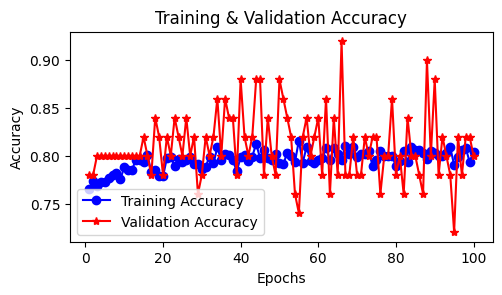

In [147]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

<ipython-input-148-a72737cf67a5>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 2)


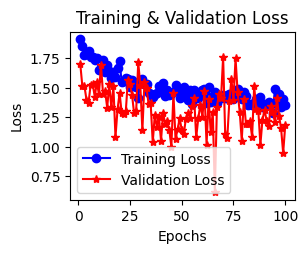

In [148]:
plt.title('Training & Validation Loss')
plt.subplot(2, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

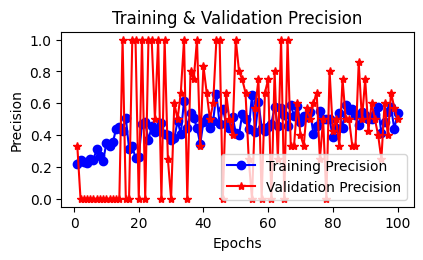

In [149]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 3)
plt.plot(epochs, precision, 'bo-', label='Training Precision')
plt.plot(epochs, val_precision, 'r*-', label='Validation Precision')
plt.title('Training & Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

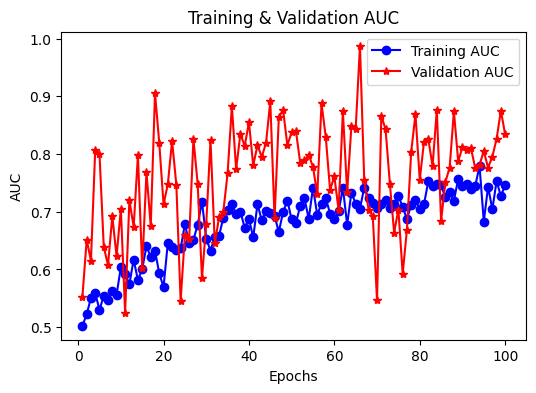

In [150]:
plt.figure(figsize=(6, 4))
plt.plot(epochs, auc, 'bo-', label='Training AUC')
plt.plot(epochs, val_auc, 'r*-', label='Validation AUC')
plt.title('Training & Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [151]:
train_score = model.evaluate(train_generator, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])


3180/3480 ━━━━━━━━━━━━━━━━━━━━ 10:41 2s/step - accuracy: 0.8168 - auc: 0.8050 - loss: 1.2139 - precision: 0.5956 - recall: 0.2609

KeyboardInterrupt: 

In [ ]:
valid_score = model.evaluate(validation_generator, verbose= 1)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])

In [152]:
predict_x = model.predict(test_generator)

498/498 ━━━━━━━━━━━━━━━━━━━━ 1076s 2s/step


In [153]:
predictions = np.argmax(predict_x, axis = 1)
print(predictions)
predictions_ = predictions.reshape(1,-1)[0]
print(classification_report(
     test_generator.classes, 
     predictions,
     target_names=['No DR (Class 0)',
                   'Mild (Class 1)',
                   'Moderate (Class 2)', 
                   'Severe (Class 3)',
                   'Proliferative DR (Class 4)'
 ]))

[3 0 0 ... 0 1 1]
                            precision    recall  f1-score   support

           No DR (Class 0)       0.22      0.40      0.28      1000
            Mild (Class 1)       0.19      0.21      0.20       971
        Moderate (Class 2)       0.15      0.03      0.04      1000
          Severe (Class 3)       0.20      0.21      0.20      1000
Proliferative DR (Class 4)       0.19      0.16      0.17      1000

                  accuracy                           0.20      4971
                 macro avg       0.19      0.20      0.18      4971
              weighted avg       0.19      0.20      0.18      4971



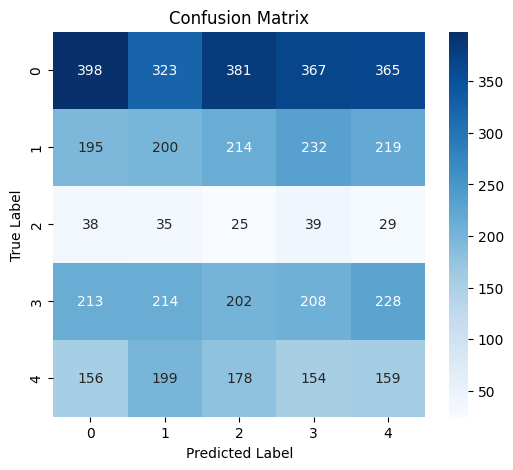

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.22      0.28      1834
           1       0.21      0.19      0.20      1060
           2       0.03      0.15      0.04       166
           3       0.21      0.20      0.20      1065
           4       0.16      0.19      0.17       846

    accuracy                           0.20      4971
   macro avg       0.20      0.19      0.18      4971
weighted avg       0.26      0.20      0.22      4971



In [154]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(predictions, test_generator.classes), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(predictions, test_generator.classes))


In [160]:
model.save('ResNetRetinopathDetection.h5')

In [165]:
image_paths = [
    "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/0/10015_left.jpeg",
    "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/1/10030_left._aug_3.jpeg",
    "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/10043_right.jpeg",
    "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/3/1002_left._aug_27._aug_4.jpeg",
    "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/4/10017_left._aug_14._aug_25.jpeg"
]

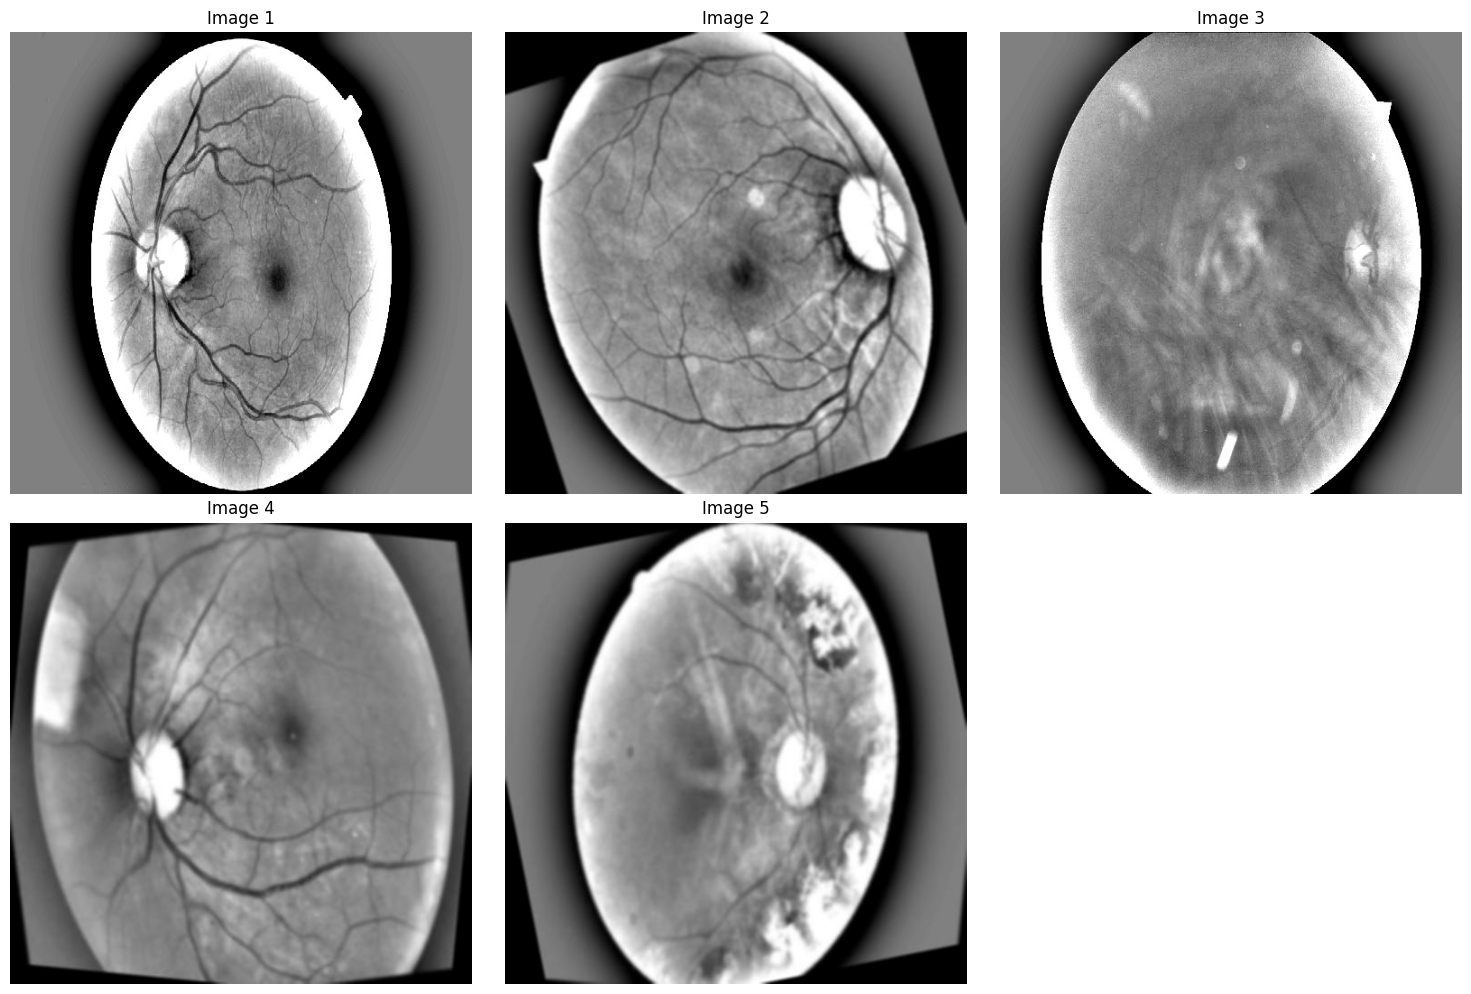

In [170]:
def display_images(image_paths, cols=3):
    rows = (len(image_paths) + cols - 1) // cols  # Calculate required rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    for i, img_path in enumerate(image_paths):
        img = image.load_img(img_path)  # Load image
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]  # Handle single row
        ax.imshow(img)
        ax.axis("off")  # Hide axes
        ax.set_title(f"Image {i+1}")

    # Hide any empty subplots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

# Call function to display images
display_images(image_paths, cols=3)


In [163]:
def preprocess_and_predict(img_path, model, target_size=(224, 224)):  # Change size if needed
    # Load and resize image
    img = image.load_img(img_path, target_size=target_size)

    # Convert image to array
    img_array = image.img_to_array(img)

    # Normalize the image (if needed)
    img_array = img_array / 255.0  # Ensure this matches your training normalization

    # Expand dimensions to fit model's input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)

    # Get class label (assuming multi-class classification)
    predicted_class = np.argmax(prediction)

    return predicted_class, prediction


In [166]:
for img_path in image_paths:
    predicted_class, confidence_scores = preprocess_and_predict(img_path, model)
    print(f"Image: {img_path}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence Scores: {confidence_scores}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Image: /kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/0/10015_left.jpeg
Predicted Class: 0
Confidence Scores: [[0.7022257  0.11346443 0.1304095  0.03796877 0.01593172]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Image: /kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/1/10030_left._aug_3.jpeg
Predicted Class: 1
Confidence Scores: [[0.16457988 0.5691938  0.12492947 0.11779648 0.0235005 ]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Image: /kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/10043_right.jpeg
Predicted Class: 4
Confidence Scores: [[0.24101888 0.02682057 0.24014358 0.04564079 0.44637626]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
Image: /kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/3/1002_left._aug_27._aug_4.jpeg
Predicted Class: 1
Confidence Scores: [[0.15622279 0.3319142  0.14248434 0.28104502 0.08833364]]

1/1 ━━━━━━━━━━━━━